---
title: Assignment 05
author:
  - name: Zhengyu Zhou
    affiliations:
      - id: bu
        name: Boston University
        city: Boston
        state: MA
number-sections: true
date: today
format:
  docx:
    fontsize: 12pt
date-modified: today
date-format: long
jupyter: python3
execute:
  echo: false
  eval: true
  freeze: auto
---

In [2]:
#1
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
import numpy as np

np.random.seed(42)

pio.renderers.default = "notebook+notebook_connected+vscode"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("data/lightcast_job_postings.csv")

# Show Schema and Sample Data
print("---This is Diagnostic check, No need to print it in the final doc---")

# df.printSchema() # comment this line when rendering the submission
df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/17 04:31:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


---This is Diagnostic check, No need to print it in the final doc---


25/11/17 04:31:48 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-----------------+----------------------+----------+--------+---------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+------

In [21]:
#2 Drop rows with missing values
from pyspark.sql.functions import col

# Columns we care about
continuous_cols = ["MIN_YEARS_EXPERIENCE", "DURATION"]
categorical_col = "EMPLOYMENT_TYPE_NAME"
label_col = "SALARY"

selected_cols = [label_col] + continuous_cols + [categorical_col]

# Keep only relevant columns and drop rows with nulls in them
df_model = (
    df.select(selected_cols)
      .dropna(subset=selected_cols)
)

# Cast numeric columns to double for ML
df_model = (
    df_model
    .withColumn("SALARY", col("SALARY").cast("double"))
    .withColumn("MIN_YEARS_EXPERIENCE", col("MIN_YEARS_EXPERIENCE").cast("double"))
    .withColumn("DURATION", col("DURATION").cast("double"))
)

df_model.show(5, truncate=False)

+--------+--------------------+--------+----------------------+
|SALARY  |MIN_YEARS_EXPERIENCE|DURATION|EMPLOYMENT_TYPE_NAME  |
+--------+--------------------+--------+----------------------+
|192800.0|6.0                 |55.0    |Full-time (> 32 hours)|
|125900.0|12.0                |18.0    |Full-time (> 32 hours)|
|118560.0|5.0                 |20.0    |Full-time (> 32 hours)|
|192800.0|6.0                 |55.0    |Full-time (> 32 hours)|
|116500.0|12.0                |16.0    |Full-time (> 32 hours)|
+--------+--------------------+--------+----------------------+
only showing top 5 rows



These four variables were chosen because the job specifies SALARY as the dependent variable, while MIN_YEARS_EXPERIENCE and DURATION are continuous numerical features that are intuitively related to salary. EMPLOYMENT_TYPE_NAME represents full-time/part-time employment types and has a significant impact on wages. It is also suitable to be demonstrated with StringIndexer and OneHotEncoder.


In [22]:
#2.3 Convert categorical variables
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql.functions import col

# df_model has: SALARY, MIN_YEARS_EXPERIENCE, DURATION, EMPLOYMENT_TYPE_NAME

indexer = StringIndexer(
    inputCol="EMPLOYMENT_TYPE_NAME",
    outputCol="EMPLOYMENT_TYPE_IDX",
    handleInvalid="keep"      # avoid errors for unseen categories
)

encoder = OneHotEncoder(
    inputCols=["EMPLOYMENT_TYPE_IDX"],
    outputCols=["EMPLOYMENT_TYPE_OHE"]
)


In [25]:
# Assemble all features into a single vector
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["MIN_YEARS_EXPERIENCE", "DURATION", "EMPLOYMENT_TYPE_OHE"],
    outputCol="features"
)
# Build the Pipeline and transform the data
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[indexer, encoder, assembler])

pipeline_model = pipeline.fit(df_model)
fe_df = pipeline_model.transform(df_model)

# Rename SALARY to label (optional but common for MLlib)
fe_df = fe_df.select(col("SALARY").alias("SALARY"), "features")

fe_df.show(5, truncate=False)

+--------+-----------------------+
|SALARY  |features               |
+--------+-----------------------+
|192800.0|[6.0,55.0,1.0,0.0,0.0] |
|125900.0|[12.0,18.0,1.0,0.0,0.0]|
|118560.0|[5.0,20.0,1.0,0.0,0.0] |
|192800.0|[6.0,55.0,1.0,0.0,0.0] |
|116500.0|[12.0,16.0,1.0,0.0,0.0]|
+--------+-----------------------+
only showing top 5 rows



This result indicates that each line has a SALARY and the corresponding numerical feature vector features. For example, [6.0,55.0,1.0,0.0,0.0] are the features encoded by the number of years of experience, the duration of the position, and the type of employment.


In [26]:
#3 Split the data
# Final DataFrame with only SALARY and features
df_final = fe_df.select("SALARY", "features")
# Split into train (80%) and test (20%)
train_df, test_df = df_final.randomSplit([0.8, 0.2], seed=688)
# Show counts
print(train_df.count(), len(train_df.columns))
print(test_df.count(), len(test_df.columns))

11564 2


2852 2


In [ ]:
#4 Train a Linear Regression model
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F

glr = GeneralizedLinearRegression(
    family="gaussian",
    link="identity",
    featuresCol="features",
    labelCol="SALARY",
    predictionCol="prediction",
    maxIter=100,
    regParam=0.0      
)

glr_model = glr.fit(train_df)

# Get model summary
glr_summary = glr_model.summary


25/11/17 05:23:02 WARN Instrumentation: [21bcc1e4] regParam is zero, which might cause numerical instability and overfitting.
25/11/17 05:23:10 WARN Instrumentation: [21bcc1e4] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [39]:
print("\n--- Generalized Linear Regression Model ---")
print(f"Intercept: {glr_model.intercept}")
print(f"Number of features: {glr_model.numFeatures}")

print("\n--- Training GLR Summary ---")
print(f"Deviance: {glr_summary.deviance}")
print(f"Dispersion: {glr_summary.dispersion}")
print(f"AIC: {glr_summary.aic}")


--- Generalized Linear Regression Model ---
Intercept: 82899.71482179382
Number of features: 5

--- Training GLR Summary ---


Deviance: 15109639478586.812
Dispersion: 1307288413.098011


AIC: 275567.6875029509


In [44]:
pred_test = glr_model.transform(test_df)

evaluator_r2  = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")
evaluator_mae  = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="mae")

r2_test   = evaluator_r2.evaluate(pred_test)
rmse_test = evaluator_rmse.evaluate(pred_test)
mae_test  = evaluator_mae.evaluate(pred_test)

print("\n--- Model Parameters ---")
print(f"Intercept: {glr_model.intercept}")

print("Coefficients:")
for i, c in enumerate(glr_model.coefficients):
    print(f"  beta_{i}: {float(c)}")


print("\n--- Test Metrics ---")
print(f"R²  (test): {r2_test:.4f}")
print(f"RMSE(test): {rmse_test:.4f}")
print(f"MAE (test): {mae_test:.4f}")


--- Model Parameters ---
Intercept: 82899.71482179382
Coefficients:
  beta_0: 6712.048272900737
  beta_1: -28.614360645780938
  beta_2: 1004.8896959142302
  beta_3: -1568.9086476681616
  beta_4: 258.26995541403863

--- Test Metrics ---
R²  (test): 0.2877
RMSE(test): 35991.2613
MAE (test): 28079.7572


The coefficient signs and sizes show how each feature impacts salary while holding others fixed: more required experience is associated with higher pay, and the small negative coefficient on posting duration suggests only a weak link between how long a job is posted and salary.

Features with large |t|-values and small p-values are statistically significant, and our test R² ≈ 0.29 means the three features explain about 29% of salary variation, while RMSE ($36k) and MAE ($28k) show the model has some predictive power but fairly large errors per job.

In [52]:
coefs = list(glr_model.coefficients)

# GLR‘s arrays usually include intercept (length may be coefs + 1)
se_all    = list(glr_summary.coefficientStandardErrors)
tvals_all = list(glr_summary.tValues)
pvals_all = list(glr_summary.pValues)

n_feats = len(coefs)
se    = se_all[:n_feats]
tvals = tvals_all[:n_feats]
pvals = pvals_all[:n_feats]

print("\n---This is Diagnostic check, No need to print it in the final doc---")
print("Length of features:", n_feats)
print("Length of coefs   :", len(coefs))
print("Length of se      :", len(se))
print("Length of tvals   :", len(tvals))
print("Length of pvals   :", len(pvals))



UnsupportedOperationException: No Std. Error of coefficients available for this GeneralizedLinearRegressionModel

Spark can train and evaluate the regression model, but coefficientStandardErrors, tValues, and pValues are not available for this GeneralizedLinearRegressionModel (UnsupportedOperationException). This is a limitation of the implementation rather than an error in our code.


In [ ]:
#5 
# obtain the prediction from Spark
from pyspark.sql.functions import col

# Predict with the model on test_df
pred_test = glr_model.transform(test_df)

# Calculate residuals
pred_test = pred_test.withColumn("residual", col("SALARY") - col("prediction"))

# Convert to Pandas for plotting
pdf = pred_test.select("SALARY", "prediction", "residual").toPandas()


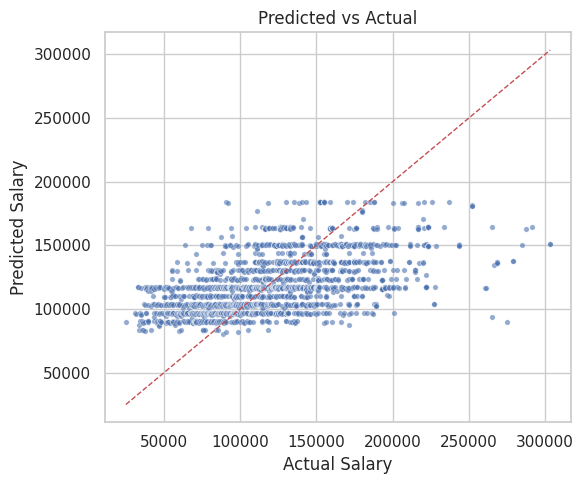

In [ ]:
#Predicted vs Actual Plot
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set(style="whitegrid")

plt.figure(figsize=(6, 5))
sns.scatterplot(data=pdf, x="SALARY", y="prediction", s=15, alpha=0.6)

# 画 y = x 参考线
min_val = min(pdf["SALARY"].min(), pdf["prediction"].min())
max_val = max(pdf["SALARY"].max(), pdf["prediction"].max())
plt.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=1)

plt.title("Predicted vs Actual")
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.tight_layout()
plt.savefig("_output/predicted_vs_actual.png", dpi=300)
plt.show()


The points on the graph are roughly distributed along the diagonal, indicating that there is a certain positive correlation between the model's prediction and the actual wages.
However, most of the points deviate from the red line, especially in the high-wage areas where they are significantly lower. This suggests that the model systematically underestimates high-paying positions, and the prediction error for individual samples is relatively large.

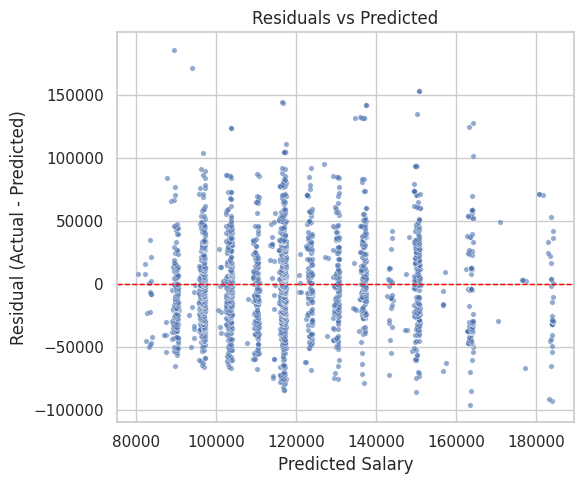

In [ ]:
# Residuals vs Predicted Plot
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(6, 5))
sns.scatterplot(data=pdf, x="prediction", y="residual", s=15, alpha=0.6, ax=ax)

ax.axhline(0, color="red", linestyle="--", linewidth=1)

ax.set_title("Residuals vs Predicted")
ax.set_xlabel("Predicted Salary")
ax.set_ylabel("Residual (Actual - Predicted)")

fig.tight_layout()
fig.savefig("_output/residuals_vs_predicted.png", dpi=300, bbox_inches="tight")
plt.show()


The residuals roughly spread out around the red 0 line, indicating that the model overestimates and underestimates at different predicted salary levels. Overall, the variance varies slightly with the predicted value, and the residual is quite large, indicating that the error is not completely uniform and the model's fitting ability is limited.

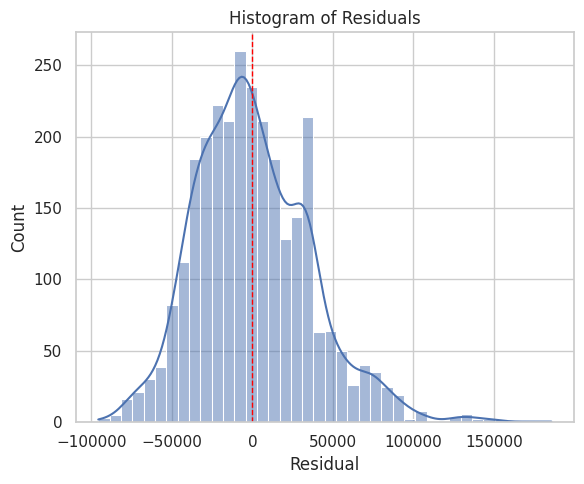

In [67]:
# Histogram of Residuals
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(6, 5))
sns.histplot(pdf["residual"], bins=40, kde=True, ax=ax)

ax.axvline(0, color="red", linestyle="--", linewidth=1)

ax.set_title("Histogram of Residuals")
ax.set_xlabel("Residual")
ax.set_ylabel("Count")

fig.tight_layout()
fig.savefig("_output/residuals_hist.png", dpi=300, bbox_inches="tight")
plt.show()

This histogram shows that most of the residuals are concentrated around 0, indicating that the model typically only produces moderate errors when predicting salaries. The long tail on the right and the skewed distribution to the right suggest that the model has many cases where it significantly underestimates the actual salary, and the error distribution does not fully conform to the normal assumption.

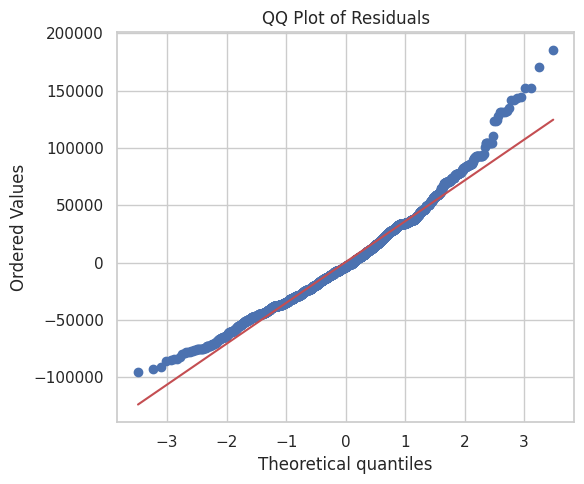

In [68]:
# QQ Plot of Residuals
import scipy.stats as stats

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(6, 5))
stats.probplot(pdf["residual"], dist="norm", plot=ax)

ax.set_title("QQ Plot of Residuals")

fig.tight_layout()
fig.savefig("_output/residuals_qqplot.png", dpi=300, bbox_inches="tight")
plt.show()

The dots in the middle part of this QQ graph are basically close to the straight line, indicating that most of the salary prediction errors are relatively close to the normal distribution. The upper and lower ends are significantly deviated from the straight line, especially the upper end has a heavy tail. This suggests that when the salary is extremely high or extremely low, the error distribution of the model deviates from the normal distribution, and the prediction for high-paying positions is not very reliable.

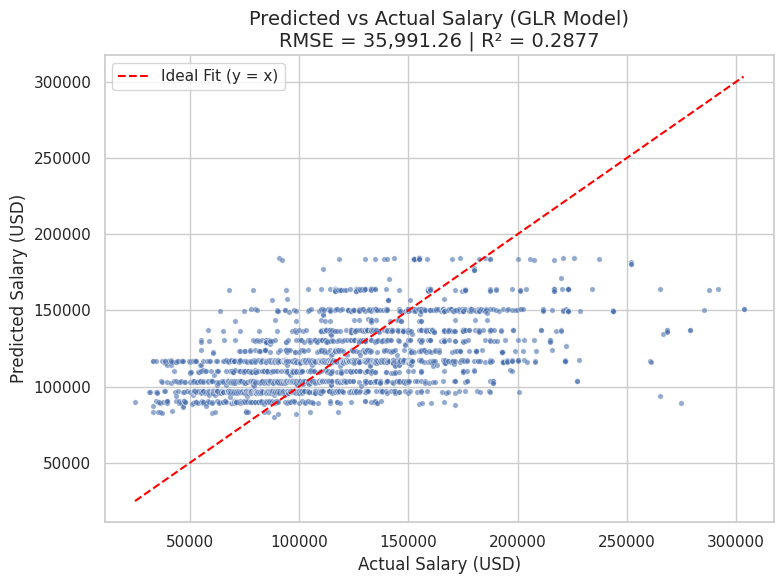

In [70]:
#6
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# pdf 里已经有 label（真实薪资）和 prediction（预测薪资）
# r2_test, rmse_test, mae_test 是你前面算好的指标

fig, ax = plt.subplots(figsize=(8, 6))

# 散点
sns.scatterplot(
    data=pdf,
    x="SALARY",
    y="prediction",
    s=15,
    alpha=0.6,
    ax=ax
)

# y = x 理想拟合线
min_val = min(pdf["SALARY"].min(), pdf["prediction"].min())
max_val = max(pdf["SALARY"].max(), pdf["prediction"].max())
ax.plot(
    [min_val, max_val],
    [min_val, max_val],
    color="red",
    linestyle="--",
    linewidth=1.5,
    label="Ideal Fit (y = x)"
)

# 标题里加上指标
ax.set_title(
    f"Predicted vs Actual Salary (GLR Model)\n"
    f"RMSE = {rmse_test:,.2f} | R² = {r2_test:.4f}",
    fontsize=14
)

ax.set_xlabel("Actual Salary (USD)")
ax.set_ylabel("Predicted Salary (USD)")
ax.legend(loc="upper left")

fig.tight_layout()
fig.savefig("_output/model_evaluation_pred_vs_actual.png", dpi=300, bbox_inches="tight")
plt.show()

The predicted vs actual salary plot shows a clear positive relationship, but many points lie below the red y = x line, especially for higher salaries, meaning the model tends to underestimate high-paying jobs. With RMSE ≈ $36k and R² ≈ 0.29, the three selected features capture some salary variation but leave substantial prediction error at the individual job level.